### 1. Linear User-based GRU

In [1]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

class LinearGRU(nn.Module):
    def __init__(self, n_users,n_items, emb_size=None, hidden_units=1000,dropout = 0.8,user_dropout = 0.5):
        super(self.__class__, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.hidden_units = hidden_units
        if emb_size == None:
            emb_size = hidden_units
        self.emb_size = emb_size
        ## todo why embeding?
        self.user_emb = nn.Embedding(n_users,emb_size)
        self.item_emb = nn.Embedding(n_items,emb_size)
        self.grucell = nn.GRUCell(input_size = emb_size*2,hidden_size = hidden_units)
        self.linear = nn.Linear(hidden_units,n_items)
        self.dropout = nn.Dropout(dropout)
        self.user_dropout = nn.Dropout(user_dropout)
        
    def forward(self, user_vectors, item_vectors):
        
        batch_size,_ = user_vectors.size()
        user_vectors = user_vectors
        item_vectors = item_vectors
        sequence_size = user_vectors.size()[1]
        
        users = self.user_dropout(self.user_emb(user_vectors))#.view(-1,sequence_size,self.emb_size)
        items = self.item_emb(item_vectors)#.view(-1,sequence_size,self.emb_size)
        
        h = torch.zeros(batch_size,self.hidden_units).to(device)
        h_t = h.unsqueeze(0)
        for i in range(sequence_size):
            gru_input = torch.cat([users[:,i,:],items[:,i,:]],dim=-1)
            h = self.grucell(gru_input,h)
            h_t = torch.cat([h_t,h.unsqueeze(0)],dim=0)
        ln_input = self.dropout(h_t[1:].transpose(0,1))
        
        output_ln = self.linear(ln_input)
        output = F.log_softmax(output_ln, dim=-1)
        return output
    


### 2. Rectified Linear User-based GRU

In [2]:
from torch.nn.parameter import Parameter
class RectifiedLinearGRU(nn.Module):

    def __init__(self, n_users,n_items, emb_size=None, hidden_units=1000,dropout = 0.8,user_dropout = 0.5):
        super(self.__class__, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.hidden_units = hidden_units
        if emb_size == None:
            emb_size = hidden_units
        self.emb_size = emb_size
        ## todo why embeding?
        self.user_emb = nn.Embedding(n_users,emb_size)
        self.item_emb = nn.Embedding(n_items,emb_size)
        self.k1 = nn.Linear(hidden_units+2*emb_size,emb_size)
        self.k2 = nn.Linear(hidden_units+2*emb_size,emb_size)
        self.grucell = nn.GRUCell(input_size = emb_size*2,hidden_size = hidden_units)
        self.linear = nn.Linear(hidden_units,n_items)
        self.dropout = nn.Dropout(dropout)
        self.user_dropout = nn.Dropout(user_dropout)
        
    def forward(self, user_vectors, item_vectors):
        batch_size,_ = user_vectors.size()
        user_vectors = user_vectors
        item_vectors = item_vectors
        sequence_size = user_vectors.size()[1]
        
        users =  self.user_dropout(self.user_emb(user_vectors))#.view(-1,sequence_size,self.emb_size)
        items = self.item_emb(item_vectors)#.view(-1,sequence_size,self.emb_size)
        
        h = torch.zeros(batch_size,self.hidden_units).to(device)
        h_t = h.unsqueeze(0)
        for i in range(sequence_size):
            rect_users = rectified_users(self,users[:,i,:],items[:,i,:],h)
            gru_input = torch.cat([rect_users,items[:,i,:]],dim=-1)
            h = self.grucell(gru_input,h)
            h_t = torch.cat([h_t,h.unsqueeze(0)],dim=0)
        ln_input = self.dropout(h_t[1:].transpose(0,1))
        output_ln = self.linear(ln_input)

        output = F.log_softmax(output_ln, dim=-1)
        return output
    
def rectified_users(self,users,items,h):
    
    k1 = self.k1(torch.cat([users,items,h],dim = -1))
    k2 = self.k2(torch.cat([users,items,h],dim = -1))
    rect_users = users
    rect_users[users<k2] = rect_users[users<k2]*0.2
    rect_users[users<k1] = 0
    return rect_users
    

### 3. Attentional User-based GRU

In [3]:
from torch.nn.parameter import Parameter
class AttentionalLinearGRU(nn.Module):
    
    def __init__(self, n_users,n_items, emb_size=None, hidden_units=1000,dropout = 0.8,user_dropout = 0.5):
        super(self.__class__, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.hidden_units = hidden_units
        if emb_size == None:
            emb_size = hidden_units
        self.emb_size = emb_size
        ## todo why embeding?
        self.user_emb = nn.Embedding(n_users,emb_size)
        self.item_emb = nn.Embedding(n_items,emb_size)
        self.grucell = nn.GRUCell(input_size = emb_size*2,hidden_size = hidden_units)
        self.att_linear = nn.Linear(hidden_units+emb_size*2,emb_size)
        torch.nn.init.constant_(self.att_linear.weight,1e-6)
        torch.nn.init.constant_(self.att_linear.bias,1e-6)
        self.linear = nn.Linear(hidden_units,n_items)
        self.dropout = nn.Dropout(dropout)
        self.user_dropout = nn.Dropout(user_dropout)
        
    def forward(self, user_vectors, item_vectors):
        batch_size,_ = user_vectors.size()
        user_vectors = user_vectors
        item_vectors = item_vectors
        sequence_size = user_vectors.size()[1]
        
        users = self.user_dropout(self.user_emb(user_vectors))#.view(-1,sequence_size,self.emb_size)
        
        items = self.item_emb(item_vectors)#.view(-1,sequence_size,self.emb_size)
        
        h = torch.zeros(batch_size,self.hidden_units).to(device)
        h_t = h.unsqueeze(0)
        for i in range(sequence_size):
            attention = F.sigmoid(self.att_linear(torch.cat([users[:,i,:],items[:,i,:],h],dim = -1)))
            gru_input = torch.cat([attention*users[:,i,:],(1-attention)*items[:,i,:]],dim=-1)
            h = self.grucell(gru_input,h)
            h_t = torch.cat([h_t,h.unsqueeze(0)],dim=0)
        ln_input = self.dropout(h_t[1:].transpose(0,1))
        output_ln = self.linear(ln_input)
        output = F.log_softmax(output_ln, dim=-1)
        return output
    
    

### 4. Multi-head Attentional User-based GRU

In [4]:
import copy

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / np.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


class MHLinearGRU(nn.Module):
    
    def __init__(self, n_users,n_items, emb_size=1000,head_num = 5,dropout = 0.8,user_dropout = 0.5):
        super(self.__class__, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.hidden_units = emb_size
        self.emb_size = emb_size
        ## todo why embeding?
        self.user_emb = nn.Embedding(n_users,emb_size)
        self.item_emb = nn.Embedding(n_items,emb_size)
        self.grucell = nn.GRUCell(input_size = emb_size*2,hidden_size = self.hidden_units)
        #self.att_linear = nn.Linear(hidden_units+emb_size*2,emb_size)
#         torch.nn.init.constant_(self.att_linear.weight,1e-6)
#         torch.nn.init.constant_(self.att_linear.bias,1e-6)
        self.linear = nn.Linear(self.hidden_units,n_items)
        self.dropout = nn.Dropout(dropout)
        self.user_dropout = nn.Dropout(user_dropout)
        self.user_attention = MultiHeadedAttention(head_num, self.emb_size)
        self.item_attention = MultiHeadedAttention(head_num, self.emb_size)
        self.bn_user = nn.BatchNorm1d(self.emb_size)
        self.bn_item = nn.BatchNorm1d(self.emb_size)
        self.bn_last = nn.BatchNorm1d(self.emb_size)
        
    def forward(self, user_vectors, item_vectors):
        batch_size,_ = user_vectors.size()
        user_vectors = user_vectors
        item_vectors = item_vectors
        sequence_size = user_vectors.size()[1]
        
        users = self.user_dropout(self.user_emb(user_vectors))#.view(-1,sequence_size,self.emb_size)
        
        items = self.item_emb(item_vectors)#.view(-1,sequence_size,self.emb_size)
        
        h = torch.zeros(batch_size,self.hidden_units).to(device)
        h_t = h.unsqueeze(0)
        for i in range(sequence_size):
            #attention = F.sigmoid(self.att_linear(torch.cat([users[:,i,:],items[:,i,:],h],dim = -1)))
            attnd_users = self.user_attention(items[:,i,:],h,users[:,i,:]).squeeze(1)
            attnd_items = self.item_attention(users[:,i,:],h,items[:,i,:]).squeeze(1)
            attnd_users = self.bn_user(attnd_users)
            attnd_items = self.bn_item(attnd_items)
            gru_input = torch.cat([attnd_users,attnd_items],dim=-1)
            h = self.grucell(gru_input,h)
            h_t = torch.cat([h_t,h.unsqueeze(0)],dim=0)
        ln_input = self.dropout(h_t[1:].transpose(0,1))
        output_ln = self.linear(ln_input)
        output = F.log_softmax(output_ln, dim=-1)
        return output
    
    

In [9]:
n_users = int(ml_test_users.max()+1)
n_items = int(np.max([ml_train_items.max()+1,ml_val_items.max()+1,ml_test_items.max()])+1)
n_users

NameError: name 'ml_test_users' is not defined

In [97]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# network = MHLinearGRU(n_users=3,n_items=3,emb_size=20).to(device)
network = MHLinearGRU(n_users=n_users,n_items=n_items).to(device)

users = np.array([[1,1,1,1,1],
                  [2,2,2,2,2]])
items = np.array([[0,1,2,1,1],
                  [0,2,2,1,0]])
pred = network(Variable(torch.LongTensor(users)).to(device),Variable(torch.LongTensor(items)).to(device))
pred.size()

torch.Size([2, 5, 10678])

### MovieLens Prerocessing

In [82]:
# Libraries and provided functions
import pandas as pd
import zipfile
import wget
from io import StringIO 
import numpy as np
import scipy as sp
from scipy import sparse
import scipy.sparse.linalg
from tqdm import tqdm # Very useful library to see progress bar during range iterations: just type `for i in tqdm(range(10)):`
from matplotlib import pyplot as plt
%matplotlib inline

from collections import namedtuple
import sys

def drop_unused_items(train,val,test):
    train_items = train.itemid.unique()
    val_items = val.itemid.unique()
    test_items = test.itemid.unique()
    
    droped_items = list((set(val_items)|set(test_items)) - set(train_items))
    val_mask = val.userid == droped_items[0]
    test_mask = test.userid == droped_items[0]
    for droped_item in droped_items:
        val_mask += val.itemid==droped_item
        test_mask += test.itemid==droped_item
    val = val[~val_mask]
    test = test[~test_mask]
    return val,test

def move_timestamps_to_end(x,max_order):
    new_order = x.groupby('timestamp', sort=True).grouper.group_info[0]
    x["timestamp"] = (max_order - new_order.max())+new_order
    return x

def normalize_timestamp(x):
    x["timestamp"] = x.groupby(['timestamp','itemid'], sort=True).grouper.group_info[0]
    return x

def set_timestamp_length(x):
    x['length'] = len(x)
    return x

def to_coo(data):
        
    user_idx, item_idx, feedback = data['userid'], data['itemid'], data['rating']
    return user_idx, item_idx, feedback

def to_matrices(data):
    data = split_by_groups(data)
    
    data_max_order = data['timestamp'].max()
    data = data.groupby("index").apply(move_timestamps_to_end,data_max_order)

    data_shape = data[['index', 'timestamp']].max()+1
    data_matrix = sp.sparse.csr_matrix((data['itemid'],
                                   (data['index'], data['timestamp'])),
                                    shape=data_shape, dtype=np.float64).todense()
    mask_matrix = sp.sparse.csr_matrix((np.ones(len(data)),
                                   (data['index'], data['timestamp'])),
                                    shape=data_shape, dtype=np.float64).todense()
    
    data_users = data.drop_duplicates(['index'])
    user_data_shape = data_users['index'].max()+1
    user_vector = sp.sparse.csr_matrix((data_users['userid'],
                                   (data_users['index'],np.zeros(user_data_shape))),
                                    shape=(user_data_shape,1), dtype=np.float64).todense()
    user_matrix = np.tile(user_vector,(1,data_shape[1]))
    return data_matrix, mask_matrix, user_matrix

def train_val_test_split(data,frac):
    data = data.groupby("userid").apply(set_timestamp_length)
    max_time_stamp = data['length']*frac
    timestamp = data['timestamp']
    data_train = data[timestamp<max_time_stamp*0.9].groupby("userid").apply(normalize_timestamp)
    data_val = data[(0.9*max_time_stamp<=timestamp)&(timestamp<0.95*max_time_stamp)]                                                       
    data_test = data[(0.95*max_time_stamp<=timestamp)&(timestamp<=max_time_stamp)]
    
    data_val, data_test = drop_unused_items(data_train,data_val,data_test)
    data_val, data_test = data_val.groupby("userid").apply(normalize_timestamp),\
                          data_test.groupby("userid").apply(normalize_timestamp)
        
    return data_train, data_val, data_test

def split_by_groups(data,group_length=20):
    data["group"] = data['timestamp']//group_length
    data["timestamp"] = data['timestamp']%group_length
    data["index"] = data.groupby(['userid','group'], sort=False).grouper.group_info[0]
    return data

def get_prepared_data(data,frac = 1):
    print("Normalizing indices to avoid gaps")
    # normalize indices to avoid gaps
    data['itemid'] = data.groupby('itemid', sort=False).grouper.group_info[0]
    data['userid'] = data.groupby('userid', sort=False).grouper.group_info[0]
    data = data.groupby("userid").apply(normalize_timestamp)

    # build sparse user-movie matrix
    print("Splitting into train, validation and test parts")
    
    data_train, data_val, data_test = train_val_test_split(data,frac)
    
    user_idx, item_idx, feedback =  to_coo(data_train.copy())
    
    train_items, train_mask, train_users= to_matrices(data_train.copy())
    val_items, val_mask, val_users = to_matrices(data_val.copy())
    test_items, test_mask, test_users = to_matrices(data_test.copy())
    
    
    print('Done.')
    return (train_items, train_mask, train_users),\
           (val_items, val_mask, val_users),\
           (test_items, test_mask, test_users),\
           (user_idx, item_idx, feedback)
        

def get_movielens_data():
    '''Downloads movielens data, normalizes users, timesteps and movies ids,
    returns data in sparse CSR format.
    '''
    print('Loading data into memory...')
    with zipfile.ZipFile("ml-10m.zip") as zfile:
        zdata = zfile.read('ml-10M100K/ratings.dat').decode()
        delimiter = ';'
        zdata = zdata.replace('::', delimiter) # makes data compatible with pandas c-engine
        ml_data = pd.read_csv(StringIO(zdata), sep=delimiter, header=None, engine='c',
                                  names=['userid', 'movieid' ,'rating','timestamp'],
                                  usecols=['userid', 'movieid','rating','timestamp'])
        ml_data['itemid'] = ml_data['movieid']
    return ml_data




In [57]:
ml_data = get_movielens_data()

(ml_train_items, ml_train_mask,ml_train_users),\
(ml_val_items, ml_val_mask,ml_val_users),\
(ml_test_items, ml_test_mask,ml_test_users),\
(ml_train_user_idx, ml_train_item_idx, ml_train_feedback) = get_prepared_data(ml_data)

# np.save("ml_train_items",ml_train_items)
# np.save('ml_train_mask',ml_train_mask)
# np.save('ml_train_users',ml_train_users)
# np.sarvalve('ml_val_items',ml_val_items)
# np.save('ml_val_mask',ml_val_mask)
# np.save('ml_val_users',ml_val_users)
# np.save('ml_test_items',ml_test_items)
# np.save('ml_test_mask',ml_test_mask)
# np.save('ml_test_users',ml_test_users)
# np.save('ml_train_user_idx',ml_train_user_idx)
# np.save('ml_train_item_idx',ml_train_item_idx)
# np.save('ml_train_feedback',ml_train_feedback)

Loading data into memory...
Normalizing indices to avoid gaps
Splitting into train, validation and test parts
Done.


In [60]:
ml_train_items = np.load("ml_train_items.npy")
ml_train_mask = np.load("ml_train_mask.npy")
ml_train_users = np.load("ml_train_users.npy")
ml_val_items = np.load("ml_val_items.npy")
ml_val_mask = np.load("ml_val_mask.npy")
ml_val_users = np.load("ml_val_users.npy")
ml_test_items = np.load("ml_test_items.npy")
ml_test_mask = np.load("ml_test_mask.npy")
ml_test_users = np.load("ml_test_users.npy")

### LastFM Prerocessing

In [3]:
import tarfile

def get_lastfm_data(frac = 0.1):
    with tarfile.TarFile("lastfm-dataset-1K.tar") as tfile:
        member = tfile.getmember('lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv')
        f = tfile.extractfile(member)
        delimiter = '\t'
        lf_data = pd.read_csv(f, sep=delimiter, header=None, engine='c',
                                  names=['userid', 'timestamp','artid','artname','traid','traname'],
                                  usecols=['userid', 'timestamp','artid','artname','traid','traname'])
        lf_data['timestamp'] = pd.to_datetime(lf_data['timestamp'])
        lf_data['itemid'] = lf_data['traname']
        lf_data['rating'] = np.ones(len(lf_data))
        lf_data = lf_data[['userid','timestamp','itemid','rating']]
        
        lf_data.itemid = lf_data.groupby('itemid', sort=False).grouper.group_info[0]
        itemid_max = lf_data.itemid.max()
        lf_data = lf_data[lf_data.itemid<=itemid_max*frac]
        
        lf_data = lf_data.drop_duplicates(['userid','timestamp','itemid'])
    return lf_data

In [11]:
lf_data = get_lastfm_data()

In [58]:
lf_data[:10]

,userid,timestamp,itemid,rating
0,user_000001,2009-05-04 23:08:57,0,1.0
1,user_000001,2009-05-04 13:54:10,1,1.0
2,user_000001,2009-05-04 13:52:04,2,1.0
3,user_000001,2009-05-04 13:42:52,3,1.0
4,user_000001,2009-05-04 13:42:11,4,1.0
5,user_000001,2009-05-04 13:38:31,5,1.0
6,user_000001,2009-05-04 13:33:28,6,1.0
7,user_000001,2009-05-04 13:23:45,7,1.0
8,user_000001,2009-05-04 13:19:22,8,1.0
9,user_000001,2009-05-04 13:13:38,9,1.0


In [83]:
lf_data = get_lastfm_data()

(lf_train_items, lf_train_mask,lf_train_users),\
(lf_val_items, lf_val_mask,lf_val_users),\
(lf_test_items, lf_test_mask,lf_test_users),\
(lf_train_user_idx, lf_train_item_idx, lf_train_feedback)= get_prepared_data(lf_data)

np.save("lf_train_items",lf_train_items)
np.save('lf_train_mask',lf_train_mask)
np.save('lf_train_users',lf_train_users)
np.save('lf_val_items',lf_val_items)
np.save('lf_val_mask',lf_val_mask)
np.save('lf_val_users',lf_val_users)
np.save('lf_test_items',lf_test_items)
np.save('lf_test_mask',lf_test_mask)
np.save('lf_test_users',lf_test_users)
np.save('lf_train_user_idx',lf_train_user_idx)
np.save('lf_train_item_idx',lf_train_item_idx)
np.save('lf_train_feedback',lf_train_feedback)

Normalizing indices to avoid gaps
Splitting into train, validation and test parts


/usr/local/lib/python3.5/dist-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Done.


In [5]:
lf_train_items = np.load("lf_train_items.npy")
lf_train_mask = np.load("lf_train_mask.npy")
lf_train_users = np.load("lf_train_users.npy")
lf_val_items = np.load("lf_val_items.npy")
lf_val_mask = np.load("lf_val_mask.npy")
lf_val_users = np.load("lf_val_users.npy")
lf_test_items = np.load("lf_test_items.npy")
lf_test_mask = np.load("lf_test_mask.npy")
lf_test_users = np.load("lf_test_users.npy")

### Training on MovieLens

In [39]:
import gc
torch.cuda.empty_cache()
gc.collect() 

133

In [8]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
n_users = int(ml_test_users.max()+1)
n_items = int(np.max([ml_train_items.max()+1,ml_val_items.max()+1,ml_test_items.max()])+1)
network = MHLinearGRU(n_users=n_users,n_items=n_items).to(device)

NameError: name 'ml_test_users' is not defined

In [89]:
import torch.utils.data
opt = torch.optim.Adam(network.parameters(),lr =0.001)

history = []

train_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.LongTensor(ml_train_users),torch.LongTensor(ml_train_items),torch.FloatTensor(ml_train_mask))),\
            batch_size=1000,shuffle=True)

val_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.LongTensor(ml_val_users),torch.LongTensor(ml_val_items),torch.FloatTensor(ml_val_mask))),\
            batch_size=1000,shuffle=True)
test_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.LongTensor(ml_test_users),torch.LongTensor(ml_test_items),torch.FloatTensor(ml_test_mask))),\
            batch_size=1000,shuffle=True)

In [6]:
import torch.utils.data
from IPython.display import clear_output
import gc



def validate_lce(network,val_loader):
    torch.cuda.empty_cache()
    gc.collect()
    network.eval()
    losses = []
    with torch.no_grad():
        for user_batch_ix,item_batch_ix, mask_batch_ix in val_loader:

            user_batch_ix = Variable(user_batch_ix).to(device)
            item_batch_ix = Variable(item_batch_ix).to(device)
            mask_batch_ix = Variable(mask_batch_ix).to(device)

            logp_seq = network(user_batch_ix, item_batch_ix)
            # compute loss
            predictions_logp = logp_seq[:, :-1]*mask_batch_ix[:, :-1,None]
            actual_next_tokens = item_batch_ix[:, 1:]

            logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])
            loss = -logp_next.sum()/mask_batch_ix[:, :-1].sum()
            losses.append(loss.cpu().data.numpy())
    torch.cuda.empty_cache()
    gc.collect() 
    return np.mean(losses)


def train_network(network,train_loader,val_loader):
    for epoch in range(10):
        i=0
        for user_batch_ix,item_batch_ix, mask_batch_ix in train_loader:
            network.train()
            user_batch_ix = Variable(user_batch_ix).to(device)
            item_batch_ix = Variable(item_batch_ix).to(device)
            mask_batch_ix = Variable(mask_batch_ix).to(device)

            logp_seq = network(user_batch_ix, item_batch_ix)
            # compute loss
            predictions_logp = logp_seq[:, :-1]*mask_batch_ix[:, :-1,None]
            actual_next_tokens = item_batch_ix[:, 1:]

            logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])
            loss = -logp_next.sum()/mask_batch_ix[:, :-1].sum()

            # train with backprop
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(network.parameters(),5)
            opt.step()
            
            if (i+1)%50==0:
                val_loss = validate_lce(network,val_loader)
                history.append(val_loss)

                clear_output(True)
                plt.title("Validation error")
                plt.plot(history)
                plt.ylabel('Cross-entropy Error')
                plt.xlabel('#iter')
                plt.show()
            i+=1
            if len(history)==100:
                return

    val_loss = validate_lce(network,val_loader)
    history.append(val_loss)

    clear_output(True)
    plt.plot(history,label='val loss')
    plt.legend()
    plt.show()


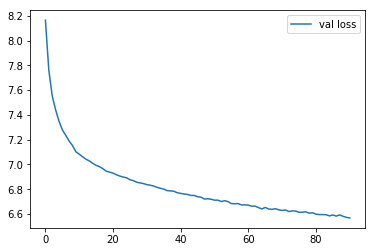

In [91]:
import gc
torch.cuda.empty_cache()
gc.collect() 
train_network(network,train_loader,val_loader)

In [93]:
torch.save(network,"network_bn_bn5mh_att_linear_ml.p")

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type MHLinearGRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type MultiHeadedAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [7]:
import numpy as np, scipy.stats as st
import numpy as np
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.95,num_parts = 5):
    part_len = len(data)//num_parts
    estimations = []
    for i in range(num_parts):
        est = np.mean(data[part_len*i:part_len*(i+1)])
        estimations.append(est)
    a = 1.0*np.array(estimations)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, h

def validate_mrr(network,k,test_loader):
    network.eval()
    losses = []
    with torch.no_grad():
        for user_batch_ix,item_batch_ix, mask_batch_ix in test_loader:
            user_batch_ix = Variable(user_batch_ix).to(device)
            item_batch_ix = Variable(item_batch_ix).to(device)
            mask_batch_ix = Variable(mask_batch_ix).to(device)

            logp_seq = network(user_batch_ix, item_batch_ix)
            # compute loss
            predictions_logp = logp_seq[:,-2]
            _,ind = torch.topk(predictions_logp, k,dim=-1)
            mrr = torch.zeros(predictions_logp.size())
            mrr.scatter_(-1,ind.cpu(),1/torch.range(1,k).repeat(*ind.size()[:-1],1).type(torch.FloatTensor).cpu())
            actual_next_tokens = item_batch_ix[:, -1]

            logp_next = torch.gather(mrr.to(device)*mask_batch_ix[:, -2,None], dim=1, index=actual_next_tokens[:,None])
#             if mask_batch_ix[:,-2].sum() >0:
            loss = logp_next.sum()/mask_batch_ix[:,-2].sum()
            losses.append(loss.cpu().data.numpy())
            torch.cuda.empty_cache()
            gc.collect() 
    m, h = mean_confidence_interval(losses)
    return m, h

def validate_recall(network,k,test_loader):
    torch.cuda.empty_cache()
    gc.collect() 
    
    network.eval()
    losses = []
    with torch.no_grad():
        for user_batch_ix,item_batch_ix, mask_batch_ix in test_loader:
            user_batch_ix = Variable(user_batch_ix).to(device)
            item_batch_ix = Variable(item_batch_ix).to(device)
            mask_batch_ix = Variable(mask_batch_ix).to(device)

            logp_seq = network(user_batch_ix, item_batch_ix)
            # compute loss
            predictions_logp = logp_seq[:, -2]
            minus_kth_biggest_logp,_ = torch.kthvalue(-predictions_logp.cpu(), k,dim=-1,keepdim=True)
            prediicted_kth_biggest = (predictions_logp>(-minus_kth_biggest_logp.to(device)))\
                                        .type(torch.FloatTensor).to(device)
            actual_next_tokens = item_batch_ix[:, -1]

            logp_next = torch.gather(prediicted_kth_biggest*mask_batch_ix[:, -2,None], dim=1, index=actual_next_tokens[:,None])
            loss = logp_next.sum()/mask_batch_ix[:,-2].sum()
            losses.append(loss.cpu().data.numpy())
    torch.cuda.empty_cache()
    gc.collect() 
    m, h = mean_confidence_interval(losses)
    return m, h

def print_scores(model,name):
    network = torch.load(model)
    mrr_score, h = validate_mrr(network,20,test_loader)
    print("MRR@20 score for ", name,": ",mrr_score,"±",h)
    recall_score, h = validate_recall(network,20,test_loader)
    print("Recall@20 score for "+name+": ",recall_score,"±",h)
    

In [45]:
print_scores("network_linear_ml.p",'Linear User-based GRU on MovieLens')

MRR@20 score for  Linear User-based GRU on MovieLens :  0.057397615 ± 0.001635190703477747
Recall@20 score for Linear User-based GRU on MovieLens:  0.18177387 ± 0.0037508356024602276


In [13]:
mrr_score, h = validate_mrr(network,20,test_loader)
print("MRR score for Linear User-based GRU: ",mrr_score)
linear_recall_score, h = validate_recall(network,20,test_loader)
# print("Recall score for Linear User-based GRU: ",linear_recall_score)

In [35]:




mean_confidence_interval(linear_mrr_score,num_parts = 5)

(0.057359595, 0.0022232151609311384)

In [25]:
len(linear_mrr_score)

77

### Training on LastFM

In [82]:
import gc
torch.cuda.empty_cache()
gc.collect() 

191

In [83]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
n_users = int(np.max([lf_train_users.max()+1,lf_val_users.max()+1,lf_test_users.max()])+1)
n_items = int(np.max([lf_train_items.max()+1,lf_val_items.max()+1,lf_test_items.max()])+1)
# with torch.cuda.device(2):
network = LinearGRU(n_users=n_users,n_items=n_items).to(device)

In [84]:
import torch.utils.data
opt = torch.optim.SGD(network.parameters(),lr =1)

history = []

train_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.LongTensor(lf_train_users),torch.LongTensor(lf_train_items),torch.FloatTensor(lf_train_mask))),\
            batch_size=100,shuffle=True)

val_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.LongTensor(lf_val_users),torch.LongTensor(lf_val_items),torch.FloatTensor(lf_val_mask))),\
            batch_size=100,shuffle=True)
test_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.LongTensor(lf_test_users),torch.LongTensor(lf_test_items),torch.FloatTensor(lf_test_mask))),\
            batch_size=100,shuffle=True)


In [85]:
network = torch.load("network_linear_lf_bs100.p")
train_network(network.to(device),train_loader,val_loader)

RuntimeError: cuda runtime error (2) : out of memory at /pytorch/aten/src/THC/generated/../generic/THCTensorMathPointwise.cu:463

In [38]:
torch.save(network,"network_linear_lf_bs100.p")

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type LinearGRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Scores

#### LastFM

In [39]:
print_scores("network_linear_lf_bs100.p",'Linear User-based GRU on LastFM')

MRR@20 score for  Linear User-based GRU on LastFM :  0.12185228 ± 0.004911310260730987
Recall@20 score for Linear User-based GRU on LastFM:  0.18590595 ± 0.00710542097175407


#### MovieLens

In [46]:
print_scores("network_linear_ml.p",'Linear User-based GRU on MovieLens')

MRR@20 score for  Linear User-based GRU on MovieLens :  0.057497583 ± 0.0007039992875517064
Recall@20 score for Linear User-based GRU on MovieLens:  0.18227212 ± 0.003842047864645815


In [52]:
print_scores("network_rect_linear_ml.p",'Rectified Linear User-based GRU on MovieLens')

MRR@20 score for  Rectified Linear User-based GRU on MovieLens :  0.060260046 ± 0.0005038204951150433
Recall@20 score for Rectified Linear User-based GRU on MovieLens:  0.19106193 ± 0.004563955364643368


In [58]:
print_scores("network_att_linear_ml.p",'Attentional User-based GRU on MovieLens')

MRR@20 score for  Attentional User-based GRU on MovieLens :  0.065337464 ± 0.0021981462220191897
Recall@20 score for Attentional User-based GRU on MovieLens:  0.1987088 ± 0.0027508449974647546


In [32]:
print_scores("network_bn5mh_att_linear_ml.p",'Multi-Head Attentional User-based GRU on MovieLens')

MRR@20 score for  Multi-Head Attentional User-based GRU on MovieLens :  0.06202981 ± 0.0017889912578660427
Recall@20 score for Multi-Head Attentional User-based GRU on MovieLens:  0.20207629 ± 0.005651086872747263
